In [82]:
import pandas as pd
import astropy.io.fits as pyfits
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('/nas/t7black/ctio_data/2018-01-06')
!pwd

/nas/t7black/ctio_data/2018-01-06


In [ ]:
filelist = glob.glob("*_???.fits")
# print(filelist)

In [ ]:
nightlog = pd.DataFrame()

In [ ]:


for i,filename in enumerate(filelist):
    print(filename)
    hdulist = pyfits.open(filename)
#     print(hdulist[0].data.shape)
    header = hdulist[0].header
    
    nightlog.loc[i, 'FILENAME'] = filename
    nightlog.loc[i, 'IMAGETYP'] = header['IMAGETYP'] 
    nightlog.loc[i, 'FILTER'] = header['FILTERS'].replace(" ","_")
    nightlog.loc[i, 'EXPTIME'] = header['EXPTIME']
    nightlog.loc[i, 'OBJECT'] = header['OBJECT']


In [ ]:
nightlog

In [ ]:
# find out what data types we have available
print(set(nightlog['IMAGETYP']))

In [ ]:
# select all bias frames
all_biases = []

is_a_bias = nightlog['IMAGETYP'] == 'zero'
bias_files = nightlog['FILENAME'][is_a_bias]

for fn in bias_files:
    hdulist = pyfits.open(fn)
    data = hdulist[0].data.astype(float)
    print(fn, data.shape)
    all_biases.append(data)
    
all_biases = np.array(all_biases)

In [ ]:
master_bias = np.nanmedian(all_biases, axis=0)
master_bias.shape

In [ ]:
pyfits.PrimaryHDU(data=master_bias).writeto("master_bias.fits", overwrite=True)

# Flat-fields

flat-fields are filter-specific, so we need to generate separate master-flats for each filter

In [ ]:
is_a_flat = (nightlog['IMAGETYP'] == 'sflat') & (nightlog['OBJECT'].str.startswith("skyflat"))
only_flats = nightlog[is_a_flat]

filter_names = set(only_flats['FILTER'])
print(filter_names)

In [ ]:
only_flats

In [ ]:
for this_filter in filter_names:
    
    is_this_filter = only_flats['FILTER'] == this_filter
    flat_files = only_flats['FILENAME'][is_this_filter]
    
    all_flats = []
    for filename in flat_files:
        print(this_filter, filename)
        
        hdulist = pyfits.open(filename)
        data = hdulist[0].data.astype(float)
        data -= master_bias
        
        # good practice: replace all bad data
        all_flats.append(data)
    
    all_flats = np.array(all_flats)
    print(all_flats.shape)
    master_flat = np.nanmean(all_flats, axis=0)
    print(master_flat.shape)
    pyfits.PrimaryHDU(data=all_flats).writeto("dummy_%s.fits" % (this_filter), overwrite=True)
    
    # Last step: Normalize the flatfield to an average level of 1
    average_flatfield_level = np.nanmedian(master_flat)
    print(average_flatfield_level)
    master_flat /= average_flatfield_level
    
    master_flat_filename = "masterflat_%s.fits" % (this_filter)
    print("Writing final masterflat: %s" % (master_flat_filename))
    pyfits.PrimaryHDU(data=master_flat).writeto(master_flat_filename, overwrite=True)
    

# Reduce actual science frames

In [ ]:
# Determine all frames that contain science data
# in this case, that's all the "OBJECT" frames, and a few more labeled as "sflat" that are actually images and NOT flatfields

is_science_frame = (nightlog['IMAGETYP'] == 'object') | \
    ((nightlog['IMAGETYP'] == 'sflat') & ~(nightlog['OBJECT'].str.startswith("skyflat")))
science_frames = nightlog[is_science_frame]

# Now process each frame in sequence
for i,frame in science_frames.iterrows():
    
    filename = frame['FILENAME']
    filter_name = frame['FILTER']
    
    # Keep user informed about what's going on
    print("Reducing raw frame: ", filename)
    
    # open raw frame
    hdulist = pyfits.open(filename)
    
    # open master flat for this specific filter
    master_flat_fn = "masterflat_%s.fits" % (filter_name)
    master_flat_hdu = pyfits.open(master_flat_fn)
    master_flat = master_flat_hdu[0].data
    
    # get raw imaging data
    data = hdulist[0].data.astype(float)
    # subtract bias
    data -= master_bias
    # divide by flatfield
    data /= master_flat
    
    # to make our life a bit easier, put some of the relevant information about each frame in the filename
    # but clean up potential issues, e.g. replace spaces with underscores
    out_fn = "%(DATE)s__%(OBJECT)s__%(FILTERS)s__%(EXPTIME).0f.fits" % hdulist[0].header
    out_fn = out_fn.replace(":", "").replace(" ","_")
    print("Writing", out_fn)
    
    pyfits.PrimaryHDU(data=data, header=hdulist[0].header).writeto(out_fn, overwrite=True)
    

# Astrometry

In [26]:
import astrometry
# import astrometry.solver
# print(astrometry.__version__)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test
INFO:root:downloading "http://data.astrometry.net/4200/index-4202-44.fits" to "/nas/t7black/astrometry/data/4200/4200/index-4202-44.fits"
DEBUG:urllib3.connectionpool:http://data.astrometry.net:80 "GET /4200/index-4202-44.fits HTTP/1.1" 200 108547200
INFO:root:downloading "http://data.astrometry.net/4200/index-4202-45.fits" to "/nas/t7black/astrometry/data/4200/4200/index-4202-45.fits"
DEBUG:urllib3.connectionpool:http://data.astrometry.net:80 "GET /4200/index-4202-45.fits HTTP/1.1" 200 109169280
INFO:root:downloading "http://data.astrometry.net/4200/index-4202-46.fits" to "/nas/t7black/astrometry/data/4200/4200/index-4202-46.fits"
DEBUG:urllib3.connectionpool:http://data.astrometry.net:80 "GET /4200/index-4202-46.fits HTTP/1.1" 200 102824640


In [ ]:
#help(astrometry)

In [ ]:
# solver = astrometry.Solver(
#     astrometry.series_4200.index_files(
#         cache_directory="/nas/t7black/astrometry/broiler.astrometry.net/~dstn/4200/",
#         scales={6},
#     )
# )

In [7]:
# load a single frame
fn = '2018-01-07T024216__ngc1365__dia_ov__180.fits'
hdulist = pyfits.open(fn)
data = hdulist[0].data

In [8]:
# get a list of stars in the field
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  

In [9]:
print(mean, median, std)

38.43499699925504 35.58875058195095 16.41193050575329


In [10]:
from photutils.detection import DAOStarFinder

In [11]:
import scipy.ndimage
filt = scipy.ndimage.median_filter(input=data, size=3, mode='reflect')

In [12]:
daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)
sources = daofind(filt - median)  

In [13]:
# only select sources away from the edges
edge = 25
near_edge = (sources['xcentroid'] < edge) | (sources['ycentroid'] < edge) | (sources['xcentroid'] > 1010) | (sources['ycentroid'] > 1010)
sources = sources[~near_edge]

In [51]:
print(sources)

 id     xcentroid          ycentroid           sharpness            roundness1            roundness2      npix sky        peak               flux                 mag         
--- ------------------ ------------------ ------------------- --------------------- --------------------- ---- --- ------------------ ------------------ ---------------------
 28 347.14650088723624 40.652065659129235  0.7961837273146923   -0.4347428991888974  -0.16821679530331404   49 0.0 54.962828441140914  1.100787207496563  -0.10425843470966215
135  743.8615353211469 209.76818724792415  0.5907349940047449  -0.17977466814006415   -0.2030704042856744   49 0.0  95.78871906813235 1.8342691659926929   -0.6586576641147189
210  882.5003799055739  319.9741082224031 0.46999538843814587  -0.11845559984154137  -0.18468493337003022   49 0.0 181.87476636122716  3.889875744383203   -1.4748393218293088
216  660.8316196786076  330.3002935442657  0.5144303185281159  -0.23999753864229276 -0.022915790537190794   49 0.0 167.039603

In [17]:
# sources.pprint(max_width=150)  

In [19]:
positions = sources[['xcentroid','ycentroid']].to_pandas().to_numpy()#.astype(int)
np.savetxt("positions.txt", positions)
# print(positions)

In [20]:
import astropy.coordinates
import astropy.units as u
source_guess = astropy.coordinates.name_resolve.get_icrs_coordinates(hdulist[0].header['OBJECT'])

In [21]:
print(source_guess)
print(source_guess.ra/u.deg, source_guess.dec/u.deg)

<SkyCoord (ICRS): (ra, dec) in deg
    (53.4019083, -36.1406583)>
53.4019083 -36.1406583


In [24]:
# solver = astrometry.Solver(
#     astrometry.series_4200.index_files(
#         cache_directory="astrometry_cache",
# #        scales={6},
#         scales={4,7,12},
#     )
# )
# idx = astrometry.series_5000.index_files(
#     cache_directory='/nas/t7black/astrometry/data/5000',
#         scales={6},
#     )
idx = astrometry.series_5000.index_files(
    cache_directory='local_cache_5000',
        scales={2,6},
    )
print(idx)

KeyboardInterrupt: 

In [29]:
idx = astrometry.series_4200.index_files(
    cache_directory='/nas/t7black/astrometry/data',
        scales={2,6},
    )
print(idx)

[PosixPath('/nas/t7black/astrometry/data/4200/index-4202-00.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-01.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-02.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-03.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-04.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-05.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-06.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-07.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-08.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-09.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-10.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-11.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-12.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-13.fits'), PosixPath('/nas/t7black/astrometry/data/4200/index-4202-14.fi

In [30]:
solver = astrometry.Solver(idx)

INFO:root:loaded 60 index files


In [32]:
solution = solver.solve(
    stars=positions,
    size_hint=     astrometry.SizeHint(
        lower_arcsec_per_pixel=0.30,
        upper_arcsec_per_pixel=0.55,
    ),
    position_hint=astrometry.PositionHint(
        ra_deg=source_guess.ra/u.deg,
        dec_deg=source_guess.dec/u.deg,
        radius_deg=1,
    ),
    solution_parameters=astrometry.SolutionParameters(),
)

print("Solution has a match?", solution.has_match())

INFO:root:solve 2: start
INFO:root:solve 2: slice=[0, 25[ (1 / 2), index="4200/index-4202-34.fits" (1 / 2)
INFO:root:solve 2: slice=[0, 25[ (1 / 2), index="4200/index-4206-08.fits" (2 / 2)
INFO:root:solve 2: slice=[25, 50[ (2 / 2), index="4200/index-4202-34.fits" (1 / 2)
INFO:root:solve 2: logodds=37.9993, matches=12, conflicts=5, distractors=31, ra=53.3996, dec=-36.1304, scale=0.405309, index="4200/index-4202-34.fits"
INFO:root:solve 2: logodds=40.3467, matches=12, conflicts=4, distractors=32, ra=53.3995, dec=-36.1304, scale=0.404914, index="4200/index-4202-34.fits"
INFO:root:solve 2: slice=[25, 50[ (2 / 2), index="4200/index-4206-08.fits" (2 / 2)


Solution has a match? True


In [33]:
solution = solver.solve(
    stars=positions,
    size_hint=     astrometry.SizeHint(
        lower_arcsec_per_pixel=0.30,
        upper_arcsec_per_pixel=0.55,
    ),
    position_hint=None,
    solution_parameters=astrometry.SolutionParameters(),
)

print("Solution has a match?", solution.has_match())

INFO:root:solve 3: start
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-00.fits" (1 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-01.fits" (2 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-02.fits" (3 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-03.fits" (4 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-04.fits" (5 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-05.fits" (6 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-06.fits" (7 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-07.fits" (8 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-08.fits" (9 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-09.fits" (10 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-4202-10.fits" (11 / 60)
INFO:root:solve 3: slice=[0, 25[ (1 / 2), index="4200/index-

Solution has a match? True


In [74]:
wcs = solution.best_match()# .astropy_wcs()
print(wcs)
wcs.to_header()

# merge header into input header
wcs_header = wcs.to_header()
for key in wcs_header:
    # print(key)
    hdulist[0].header[key] = (wcs_header[key], wcs_header.comments[key]) 
    
print(repr(hdulist[0].header))
hdulist.writeto("dummy_calibrated.fits", overwrite=True)

Match(logodds=40.34669494628906, center_ra_deg=53.39945420921245, center_dec_deg=-36.13038916119913, scale_arcsec_per_pixel=0.4049137201353035, index_path=PosixPath('/nas/t7black/astrometry/data/4200/index-4202-34.fits'), stars=(Star(ra_deg=53.45654100769637, dec_deg=-36.12864698409525, metadata={'j_mag': 13.548999786376953}), Star(ra_deg=53.476637985680426, dec_deg=-36.13319801060871, metadata={'j_mag': 12.071000099182129}), Star(ra_deg=53.373136986302505, dec_deg=-36.09738499604271, metadata={'j_mag': 16.079999923706055}), Star(ra_deg=53.4015950002115, dec_deg=-36.14047599304273, metadata={'j_mag': 11.343999862670898}), Star(ra_deg=53.40723598837045, dec_deg=-36.135796002031285, metadata={'j_mag': 15.060999870300293}), Star(ra_deg=53.36291898725138, dec_deg=-36.12852899105486, metadata={'j_mag': 16.090999603271484}), Star(ra_deg=53.40233999310698, dec_deg=-36.142001989472114, metadata={'j_mag': 11.83899974822998}), Star(ra_deg=53.41870399466764, dec_deg=-36.141124989693694, metadata=

AttributeError: 'Match' object has no attribute 'to_header'

In [75]:
print(wcs.wcs_fields)

{'WCSAXES': (2, 'Number of coordinate axes'), 'EQUINOX': (2000.0, 'Equatorial coordinates definition (yr)'), 'LONPOLE': (180.0, 'Native longitude of celestial pole (deg)'), 'LATPOLE': (0.0, 'Native latitude of celestial pole (deg)'), 'CRVAL1': (53.39616910393312, 'RA of reference point'), 'CRVAL2': (-36.131732759727036, 'DEC of reference point'), 'CRPIX1': (582.8121706018029, 'X reference pixel'), 'CRPIX2': (533.5549951768455, 'Y reference pixel'), 'CUNIT1': ('deg', 'X pixel scale units'), 'CUNIT2': ('deg', 'Y pixel scale units'), 'CD1_1': (-0.00011247200640591568, 'Transformation matrix'), 'CD1_2': (9.517656662447828e-07, 'Transformation matrix'), 'CD2_1': (-9.517656662447844e-07, 'Transformation matrix'), 'CD2_2': (-0.00011247200640591569, 'Transformation matrix'), 'CTYPE1': ('RA---TAN-SIP', 'TAN (gnomonic) projection + SIP distortions'), 'CTYPE2': ('DEC--TAN-SIP', 'TAN (gnomonic) projection + SIP distortions')}


In [73]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 53.39616910393312  -36.13173275972704  
CRPIX : 582.8121706018029  533.5549951768455  
CD1_1 CD1_2  : -0.00011247200640591  9.51765666244782e-07  
CD2_1 CD2_2  : -9.5176566624478e-07  -0.00011247200640591  
NAXIS : 0  0


In [38]:
# help(wcs)

In [114]:
def calibrate_astrometry(input_fn, output_fn, src_n_sigma=15, target_name='auto', sip_order=1):
    
    logger = logging.getLogger("AstroCal")
    logger.info("Starting work on %s" % (input_fn))
    hdulist = pyfits.open(input_fn)
    data = hdulist[0].data
    
    logger.debug("smoothing frame to get fewer stars")
    filt = scipy.ndimage.median_filter(input=data, size=3, mode='reflect')
    
    logger.debug("Finding sources")
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)
    sources = daofind(filt - median)  
    logger.info("Found %d sources in total" % (len(sources)))
    edge = 25
    near_edge = (sources['xcentroid'] < edge) | (sources['ycentroid'] < edge) | (sources['xcentroid'] > 1010) | (sources['ycentroid'] > 1010)
    sources = sources[~near_edge]
    if (len(sources) > 100):
        # select the top 100 brightest sources
        flux_sort = np.argsort(sources['flux'])[::-1]
        # print(sources['flux'][flux_sort])
        sources = sources[flux_sort[:100]]

    positions = sources[['xcentroid','ycentroid']].to_pandas().to_numpy()
    logger.info("Using %d sources for astrometry" % (positions.shape[0]))
    
    # getting source guess
    if (target_name == 'auto'):
        target_name = hdulist[0].header['OBJECT']
    position_hint = None
    if (target_name is not None):
        try:
            source_guess = astropy.coordinates.name_resolve.get_icrs_coordinates(target_name)
            position_hint=astrometry.PositionHint(
                ra_deg=source_guess.ra/u.deg,
                dec_deg=source_guess.dec/u.deg,
                radius_deg=3,
            )
            logger.info("Using position hint for %s: %s" % (target_name, str(repr(source_guess))))
        except:
            pass
    
    idx = astrometry.series_4200.index_files(
        cache_directory='/nas/t7black/astrometry/data',
        scales={2,6},
    )
        
    solution = solver.solve(
        stars=positions,
        size_hint=     astrometry.SizeHint(
            lower_arcsec_per_pixel=0.30,
            upper_arcsec_per_pixel=0.55,
        ),
        position_hint=position_hint,
        solution_parameters=astrometry.SolutionParameters(sip_order=sip_order),
    )
    logger.info("Solution has a match? %s" % ('yes' if solution.has_match() else 'no'))
    
    if (solution.has_match()):
        wcs = solution.best_match() #.astropy_wcs()
        print(wcs)
        
        # wcs.astropy_wcs().to_header()

        # merge header into input header
        wcs_header = wcs.wcs_fields #wcs.to_header()
        for key in wcs_header:
            # print(key)
            hdulist[0].header[key] = wcs_header[key] #(wcs_header[key], wcs_header.comments[key]) 

        hdulist[0].header['CTYPE1'] = "RA---TAN"
        hdulist[0].header['CTYPE2'] = "DEC--TAN"
        logger.info("Writing output file to %s" % (output_fn))
        # print(repr(hdulist[0].header))
        hdulist.writeto(output_fn, overwrite=True)
        
        return wcs, positions
    else:
        logger.error("No solution found, not writing output file")
        return None, positions

In [109]:
wcs, positions = calibrate_astrometry('2018-01-07T032042__47tuc__dia_r__60.fits', 'cal_47tuc_r.fits')

INFO:AstroCal:Starting work on 2018-01-07T032042__47tuc__dia_r__60.fits
DEBUG:AstroCal:smoothing frame to get fewer stars
DEBUG:AstroCal:Finding sources
INFO:AstroCal:Found 3206 sources in total
INFO:AstroCal:Using 100 sources for astrometry
INFO:AstroCal:Using position hint for 47tuc: <SkyCoord (ICRS): (ra, dec) in deg
    (6.0223292, -72.0814444)>
INFO:root:solve 27: start
INFO:root:solve 27: slice=[0, 25[ (1 / 4), index="4200/index-4202-32.fits" (1 / 2)
INFO:root:solve 27: slice=[0, 25[ (1 / 4), index="4200/index-4206-08.fits" (2 / 2)
INFO:root:solve 27: slice=[25, 50[ (2 / 4), index="4200/index-4202-32.fits" (1 / 2)
INFO:root:solve 27: slice=[25, 50[ (2 / 4), index="4200/index-4206-08.fits" (2 / 2)
INFO:root:solve 27: slice=[50, 75[ (3 / 4), index="4200/index-4202-32.fits" (1 / 2)
INFO:root:solve 27: logodds=61.3537, matches=17, conflicts=2, distractors=66, ra=5.99792, dec=-72.0763, scale=0.40118, index="4200/index-4202-32.fits"


KeyboardInterrupt: 

In [99]:
# calibrate_astrometry('2018-01-07T032629__47tuc__dia_b__120.fits', 'cal_47tuc_b.fits')

In [104]:
wcs, positions = calibrate_astrometry('2018-01-07T024216__ngc1365__dia_ov__180.fits', 'cal_ngc1365_v.fits', sip_order=3)

INFO:AstroCal:Starting work on 2018-01-07T024216__ngc1365__dia_ov__180.fits
DEBUG:AstroCal:smoothing frame to get fewer stars
DEBUG:AstroCal:Finding sources
INFO:AstroCal:Found 702 sources in total
INFO:AstroCal:Using 61 sources for astrometry
INFO:AstroCal:Using position hint for ngc1365: <SkyCoord (ICRS): (ra, dec) in deg
    (53.4019083, -36.1406583)>
INFO:root:solve 25: start
INFO:root:solve 25: slice=[0, 25[ (1 / 2), index="4200/index-4202-34.fits" (1 / 2)
INFO:root:solve 25: slice=[0, 25[ (1 / 2), index="4200/index-4206-08.fits" (2 / 2)
INFO:root:solve 25: slice=[25, 50[ (2 / 2), index="4200/index-4202-34.fits" (1 / 2)
INFO:root:solve 25: logodds=37.9993, matches=12, conflicts=5, distractors=31, ra=53.3996, dec=-36.1304, scale=0.405309, index="4200/index-4202-34.fits"
INFO:root:solve 25: logodds=40.3467, matches=12, conflicts=4, distractors=32, ra=53.3995, dec=-36.1304, scale=0.404914, index="4200/index-4202-34.fits"
INFO:root:solve 25: slice=[25, 50[ (2 / 2), index="4200/index-4

Match(logodds=40.34669494628906, center_ra_deg=53.39945420921245, center_dec_deg=-36.13038916119913, scale_arcsec_per_pixel=0.4049137201353035, index_path=PosixPath('/nas/t7black/astrometry/data/4200/index-4202-34.fits'), stars=(Star(ra_deg=53.45654100769637, dec_deg=-36.12864698409525, metadata={'j_mag': 13.548999786376953}), Star(ra_deg=53.476637985680426, dec_deg=-36.13319801060871, metadata={'j_mag': 12.071000099182129}), Star(ra_deg=53.373136986302505, dec_deg=-36.09738499604271, metadata={'j_mag': 16.079999923706055}), Star(ra_deg=53.4015950002115, dec_deg=-36.14047599304273, metadata={'j_mag': 11.343999862670898}), Star(ra_deg=53.40723598837045, dec_deg=-36.135796002031285, metadata={'j_mag': 15.060999870300293}), Star(ra_deg=53.36291898725138, dec_deg=-36.12852899105486, metadata={'j_mag': 16.090999603271484}), Star(ra_deg=53.40233999310698, dec_deg=-36.142001989472114, metadata={'j_mag': 11.83899974822998}), Star(ra_deg=53.41870399466764, dec_deg=-36.141124989693694, metadata=

In [115]:
wcs, positions = calibrate_astrometry('2018-01-07T021946__30doradus__dia_b__120.fits', 'cal_30dor_b.fits', sip_order=1)

INFO:AstroCal:Starting work on 2018-01-07T021946__30doradus__dia_b__120.fits
DEBUG:AstroCal:smoothing frame to get fewer stars
DEBUG:AstroCal:Finding sources
INFO:AstroCal:Found 1474 sources in total
INFO:AstroCal:Using 100 sources for astrometry
INFO:AstroCal:Using position hint for 30doradus: <SkyCoord (ICRS): (ra, dec) in deg
    (84.67665, -69.1009333)>
INFO:root:solve 29: start
INFO:root:solve 29: slice=[0, 25[ (1 / 4), index="4200/index-4202-32.fits" (1 / 4)
INFO:root:solve 29: slice=[0, 25[ (1 / 4), index="4200/index-4202-36.fits" (2 / 4)
INFO:root:solve 29: slice=[0, 25[ (1 / 4), index="4200/index-4206-08.fits" (3 / 4)
INFO:root:solve 29: slice=[0, 25[ (1 / 4), index="4200/index-4206-09.fits" (4 / 4)
INFO:root:solve 29: slice=[25, 50[ (2 / 4), index="4200/index-4202-32.fits" (1 / 4)
INFO:root:solve 29: slice=[25, 50[ (2 / 4), index="4200/index-4202-36.fits" (2 / 4)
INFO:root:solve 29: slice=[25, 50[ (2 / 4), index="4200/index-4206-08.fits" (3 / 4)
INFO:root:solve 29: slice=[25,

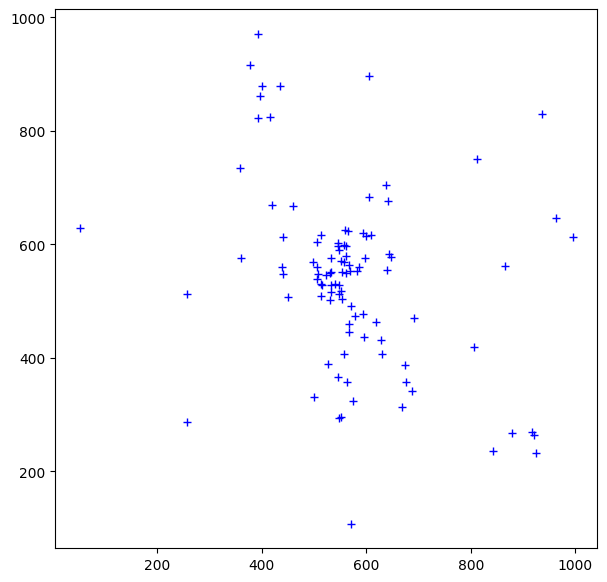

In [113]:
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(positions[:,0], positions[:,1], c='blue', marker='+', linewidth=1)

if (wcs is not None):
    awcs = solution.best_match().astropy_wcs()
    pixels = awcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
    # print(pixels)

    ax.scatter(pixels[:,0], pixels[:,1], marker='o', edgecolor='red', facecolor='none')

